In [1]:
# Read ground truth file

ground_truth = []
ground_truth_file = "/mnt/c/Users/zhenh/tax_data/sampled_reads.label"
with open(ground_truth_file, 'r') as gt:
    for line in gt:
        ground_truth.append(int(line))

In [2]:
# Read GTDB metadata
import pandas as pd

gtdb_metadata = pd.read_csv('/mnt/c/Users/zhenh/tax_data/bac120_metadata.tsv',sep='\t')
species_set = set(gtdb_metadata["ncbi_species_taxid"])
len(species_set)

/tmp/ipykernel_778/2040866023.py:4: DtypeWarning: Columns (61,63,65,74,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  gtdb_metadata = pd.read_csv('/mnt/c/Users/zhenh/tax_data/bac120_metadata.tsv',sep='\t')


57939

In [3]:
# Read Kraken 2 output
kraken2_predictions = []

kraken2_output_file = "/mnt/c/Users/zhenh/tax_data/kraken2.output"
with open(kraken2_output_file, 'r') as f:
    for line in f:
        kraken2_predictions.append(int(line.split("\t")[2]))


In [38]:
len(kraken2_predictions)

72000

In [4]:
# Evaluate correctness
from ete3 import NCBITaxa
import numpy as np

ncbi = NCBITaxa()

def get_level(ID, level='genus'):
    """
    Find the genus of a given species ID.
    """
    if ID is None:
        return None
        
    # Get the lineage of the species
    try:
        lineage = ncbi.get_lineage(int(ID))
        ranks = ncbi.get_rank(lineage)
    except:
        return None

    #print(ranks)
    for i in ranks:
        if ranks[i] == level:
            return i
        
    return None



species_correct = np.full(len(ground_truth), False, dtype=bool)
genus_correct = np.full(len(ground_truth), False, dtype=bool)
in_db = np.full(len(ground_truth), False, dtype=bool)
prediction_at_species_level = np.full(len(ground_truth), False, dtype=bool)

for i in range(len(ground_truth)):
    if get_level(ground_truth[i], 'species') == get_level(kraken2_predictions[i], 'species'):
        species_correct[i] = True
    if get_level(ground_truth[i]) == get_level(kraken2_predictions[i]):
        genus_correct[i] = True
    if get_level(ground_truth[i], 'species') in species_set:
        in_db[i] = True
    rank = ncbi.get_rank([kraken2_predictions[i]])
    if rank is not None and len(rank) != 0:
        #print(rank[kraken2_predictions[i]])
        if rank[kraken2_predictions[i]] in ['species', 'strain']:
            prediction_at_species_level[i] = True


In [7]:
np.sum(species_correct)

49742

In [71]:
ground_truth_genus = []
for gt in species_set:
    ground_truth_genus.append(get_level(gt, 'species'))

species_set = set(ground_truth_genus)

/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1704088 was translated into 1335043
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2823888 was translated into 38303
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 417 was translated into 17
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2750980 was translated into 2070537
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:24

In [5]:
data = {"Ground Truth": ground_truth, "kraken2_predictions": kraken2_predictions, "species_correct": species_correct,
        "genus_correct": genus_correct, "in_db": in_db, "prediction_at_species_level": prediction_at_species_level,
        "count": np.full(len(ground_truth), 1)}
result = pd.DataFrame(data)
result

,Ground Truth,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
0,100886,100886,True,True,True,True,1
1,100886,100886,True,True,True,True,1
2,100886,100886,True,True,True,True,1
3,100886,100886,True,True,True,True,1
4,100886,100886,True,True,True,True,1
...,...,...,...,...,...,...,...
71995,901,411464,True,True,True,True,1
71996,901,411464,True,True,True,True,1
71997,901,411464,True,True,True,True,1
71998,901,411464,True,True,True,True,1


In [9]:
np.sum(result['prediction_at_species_level'])

69011

In [6]:
sum_res = result.groupby('Ground Truth').sum()
for feature in ['species_correct', 'genus_correct', 'in_db', 'prediction_at_species_level']:
    sum_res[feature] /= sum_res['count']

sum_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
Ground Truth,,,,,,
817,311940123,0.889,0.9230,1.0,0.9800,1000
818,568103998,0.833,0.9645,1.0,0.9560,2000
901,411009236,0.986,0.9870,1.0,0.9900,1000
1261,1280412914,0.494,0.9740,1.0,0.9905,2000
1358,228843030,0.785,0.9110,1.0,0.9530,1000
...,...,...,...,...,...,...
1232452,1605582687,0.000,0.0400,1.0,0.9780,1000
1232457,2132609851,0.000,0.1790,1.0,0.8980,1000
1297617,1305794943,0.957,0.9570,1.0,0.9920,1000


In [7]:
in_domain_res = sum_res[sum_res["in_db"] >= 1]

in_domain_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
Ground Truth,,,,,,
817,311940123,0.889,0.9230,1.0,0.9800,1000
818,568103998,0.833,0.9645,1.0,0.9560,2000
901,411009236,0.986,0.9870,1.0,0.9900,1000
1261,1280412914,0.494,0.9740,1.0,0.9905,2000
1358,228843030,0.785,0.9110,1.0,0.9530,1000
...,...,...,...,...,...,...
1226322,1182891120,0.000,0.0100,1.0,0.6900,1000
1232452,1605582687,0.000,0.0400,1.0,0.9780,1000
1232457,2132609851,0.000,0.1790,1.0,0.8980,1000


In [21]:
in_domain_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
Ground Truth,,,,,,
817,311940123,0.889,0.9230,1.0,0.9800,1000
818,568103998,0.833,0.9645,1.0,0.9560,2000
901,411009236,0.986,0.9870,1.0,0.9900,1000
1261,1280412914,0.494,0.9740,1.0,0.9905,2000
1358,228843030,0.785,0.9110,1.0,0.9530,1000
1507,1581573143,0.000,0.0010,1.0,0.9590,1000
1509,39082565,0.910,0.9670,1.0,0.9650,1000
1535,435959301,0.969,0.9870,1.0,0.9840,1000
1680,543296972,0.719,0.9170,1.0,0.9490,1000


In [10]:
result[result["Ground Truth"] == 411489]

,Ground Truth,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
41000,411489,2109691,False,False,True,True,1
41001,411489,2109691,False,False,True,True,1
41002,411489,2109691,False,False,True,True,1
41003,411489,2109691,False,False,True,True,1
41004,411489,2109691,False,False,True,True,1
...,...,...,...,...,...,...,...
41995,411489,2109691,False,False,True,True,1
41996,411489,2109691,False,False,True,True,1
41997,411489,2109691,False,False,True,True,1
41998,411489,2109691,False,False,True,True,1


In [11]:
ncbi.get_taxid_translator([411489, 2109691])

{411489: 'Clostridium sp. L2-50', 2109691: 'Lachnospiraceae bacterium GAM79'}

In [8]:
out_domain_res = sum_res[sum_res["in_db"] <= 0]

out_domain_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
Ground Truth,,,,,,
2860054,1812151353,0.0,0.908,0.0,0.923,1000


/tmp/ipykernel_778/1629055615.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


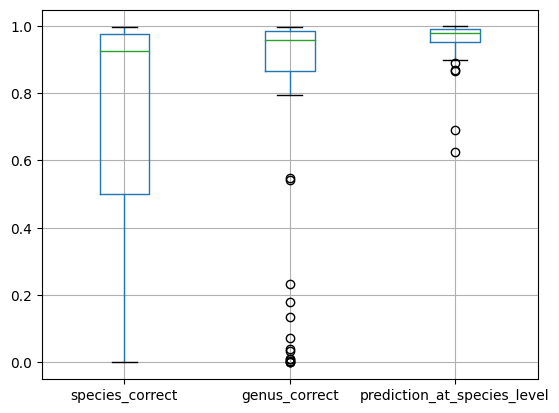

In [12]:
import matplotlib.pyplot as plt

plot = plt.figure()
sum_res.boxplot(column=["species_correct", "genus_correct", "prediction_at_species_level"])
plot.show()
plot.savefig("res.pdf", format='pdf')